# How does population look like without the impact of the HIV/AIDS epidemic?
Modeling and Simulation - Project 1

Skye Ozga, HK Rho

### Reading the Data

In [791]:
#######NEW PROJECT########
#QUESTION: compare the actual data graph population to the graph without the HIV/AIDS epidemic 
#          so that we can see by what factor the population differs in two situations

#import all the libraries
from modsim import *
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

#import all the data
BPDdata = pd.read_csv("BPD.csv", index_col = ['Year'], skiprows = 3, nrows = 57);


population change, birth rate, death rate change due to the aids epidemic in Sub-Saharan Africa

Question:
By what factor will the population change if the effects of the HIV/AIDS epidemic are disregarded compared to the actual population graph?

Methodology/Model:
The deaths caused by HIV/AIDS can be disregarded from the overall death rate of the entire population of the country we are analyzing, so that we can compare two situations with and without HIV/AIDS.

Results:
There is no results yet, but the results will consist of two graphs that each show the population change with and without HIV/AIDS.

Interpretation:
After generating the graphs, the amount by which one differs from the other can be observed/calculated.

In [792]:
country_list = ['Angola'    , 'Botswana', 'Eswatini'   , 'Lesotho' , 'Malawi', 
                'Mozambique', 'Namibia' , 'SouthAfrica', 'Zimbabwe', 'Zambia']

#years 1970-2030
T_START = 1980
T_1990  = 1990
T_2016  = 2016
T_END   = 2030
years = [x for x in range(1980,2017)];

#AIDS years: 1990-2016
years_AIDS = [x for x in range(1990,2017)];

In [793]:
class Country:
    
    def __init__(self, name, data = TimeSeries()):

        if not data.empty:
            #Initialize data for each country
            self.name      = name
            self.br_data   = TimeSeries()
            self.dr_data   = TimeSeries()
            self.da        = TimeSeries()
            
            
            #pop[T_START] is initial population parameter
            self.pop_data  = TimeSeries()
            
            
            #reads data from main spreadsheet 
            for t in range(T_START, T_2016 + 1):
                self.br_data[t] = data[name + 'BR'][t]
            for t in range(T_START, T_2016 + 1):
                self.da[t] = data[name + 'DA'][t]
            for t in range(T_START, T_2016 + 1):
                self.dr_data[t] = data[name + 'DR'][t]
            for t in range(T_START, T_2016 + 1):
                self.pop_data[t] = data[name + 'Pop'][t]
                
                
            #br and dr in arrays bc numpy doesn't like dataframes
            self.br_array  = [self.br_data[y] for y in years]
            self.dr_array  = [self.dr_data[y] for y in years]
            
            
            #Initializes population state variable
            self.pop       = TimeSeries()
        
        
            #generate br/dr models from linear fit of data
            self.br_AIDS_model = TimeSeries()
            m1, b1 = np.polyfit(years, self.br_array,1)
            for t in linrange(T_START, T_END+1):
                self.br_AIDS_model[t] = m1*(t) + b1
        
            self.dr_AIDS_model = TimeSeries()
            m2, b2 = np.polyfit(years, self.dr_array,1)
            for t in linrange(T_START, T_END+1):
                self.dr_AIDS_model[t] = m2*(t) + b2
                
            
            #modify br/dr data to eliminate AIDS-related deaths
            self.br_noAIDS = TimeSeries()
            for t in linrange(T_START, T_2016+1):
                self.br_noAIDS[t] = self.br_data[t]
                if t >= T_1990:
                    self.br_noAIDS[t] = self.br_data[t] + self.br_data[t] * self.da[t]/(1000.0*self.pop_data[t])
            
            self.dr_noAIDS = TimeSeries()
            for t in linrange(T_START, T_2016+1):
                self.dr_noAIDS[t] = self.dr_data[t]
                if t >= T_1990: 
                    self.dr_noAIDS[t] = self.dr_data[t] - 1000.0*self.da[t]/self.pop_data[t]

                    
            #once again, numpy doesn't like DataFrames
            self.br_array_noAIDS  = [self.br_noAIDS[y] for y in years]
            self.dr_array_noAIDS  = [self.dr_noAIDS[y] for y in years]
            
            
            #linear fit for modified br/dr data
            self.br_noAIDS_model = TimeSeries()
            m3, b3 = np.polyfit(years, self.br_array_noAIDS, 1)
            for t in linrange(T_START, T_END+1):
                self.br_noAIDS_model[t] = m3*(t) + b3
        
            self.dr_noAIDS_model = TimeSeries()
            m4, b4 = np.polyfit(years, self.dr_array_noAIDS, 1)
            for t in linrange(T_START, T_END+1):
                self.dr_noAIDS_model[t] = m4*(t) + b4
                
                
        else:
            
            #pseudo-overloaded constructor to make a blank country object
            self.name      = name
            self.br_data   = TimeSeries()
            self.dr_data   = TimeSeries()
            self.da        = TimeSeries()
            self.pop_data  = TimeSeries()
            self.br_array  = [0]
            self.dr_array  = [0]
            self.pop       = TimeSeries()
        
            self.br_AIDS_model   = TimeSeries()
            self.dr_AIDS_model   = TimeSeries()
            self.br_noAIDS_model = TimeSeries()
            self.dr_noAIDS_model = TimeSeries()
            
    def update(self, t, aids = True):
        #start by making the state population 
        #equal to the system starting population
        if t == T_START:
            self.pop[t] = self.pop_data[t]
            return self.pop[t]
        
        #This is so that the TimeSeries knows it's getting another value
        self.pop[t] = self.pop[t-1]
        delta = 0
        
        #updates the population based on the br/dr of the respective model
        #(AIDS or no AIDS)
        if aids:
            delta = self.pop[t-1]*(self.br_AIDS_model[t] - self.dr_AIDS_model[t])/1000
        else:
            delta = self.pop[t-1]*(self.br_noAIDS_model[t] - self.dr_noAIDS_model[t])/1000
        
        
        #spits out the updated population data
        self.pop[t] += delta
        return self.pop[t]
                
print('this cell worked!')
            

this cell worked!


In [794]:
def run_simulation(country, aids = True, start = T_START, end = T_END):
    #get the results
    results = TimeSeries()
    for t in range(start, end+1):
        results[t] = country.update(t, aids)
    
    #plot the results
    if aids:
        plt.plot(country.pop, label = country.name + ' With AIDS')
    else:
        plt.plot(country.pop, label = country.name + ' Without AIDS')

In [795]:
#generates all the Country Objects
countries = [Country(c, BPDdata) for c in country_list];

print('this one too!')


this one too!


In [796]:
#generates a blank 'Country' with the to keep track of totals for the region
total = Country('Cumulative')

#sum all the population and AIDS death data
for t in range(T_START, T_2016+1):
    total.da[t]        = 0.0
    total.pop_data[t]  = 0.0
    for c in countries:
            total.pop_data[t] += c.pop_data[t]
            total.da[t]       += c.da[t]

#average the BR and DR data
for t in range(T_START, T_2016+1):
    total.br_data[t]          = 0.0
    total.dr_data[t]          = 0.0
    
    for c in countries:
        total.br_data[t]          += c.br_data[t]*c.pop_data[t]/total.pop_data[t]
        total.dr_data[t]          += c.dr_data[t]*c.pop_data[t]/total.pop_data[t]
    
#average the BR and DR models        
for t in range(T_START, T_END+1):
    total.br_AIDS_model[t]   = 0.0
    total.dr_AIDS_model[t]   = 0.0
    total.br_noAIDS_model[t] = 0.0
    total.dr_noAIDS_model[t] = 0.0
    
    for c in countries:
        total.br_AIDS_model[t]   += c.br_AIDS_model[t]*c.pop_data[T_2016]/total.pop_data[T_2016]
        total.dr_AIDS_model[t]   += c.dr_AIDS_model[t]*c.pop_data[T_2016]/total.pop_data[T_2016]
        total.br_noAIDS_model[t] += c.br_noAIDS_model[t]*c.pop_data[T_2016]/total.pop_data[T_2016]
        total.dr_noAIDS_model[t] += c.dr_noAIDS_model[t]*c.pop_data[T_2016]/total.pop_data[T_2016]

#add the region to the countries array
countries.append(total)

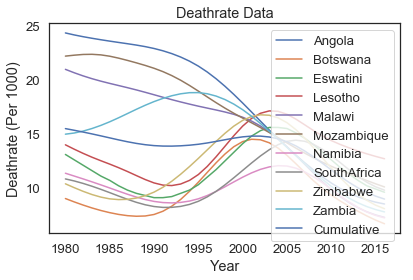

In [797]:
for c in countries:
    plt.plot(c.dr_data, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Deathrate (Per 1000)',
             title='Deathrate Data')

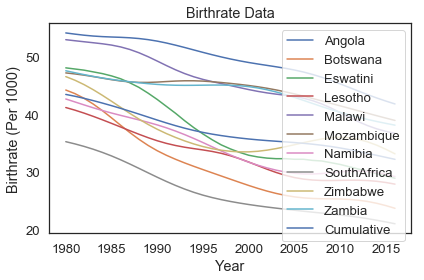

In [798]:
for c in countries:
    plt.plot(c.br_data, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Birthrate (Per 1000)',
             title='Birthrate Data')

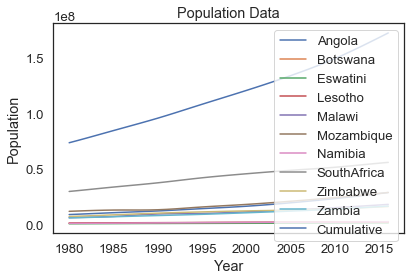

In [799]:
for c in countries:
    plt.plot(c.pop_data, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Data')

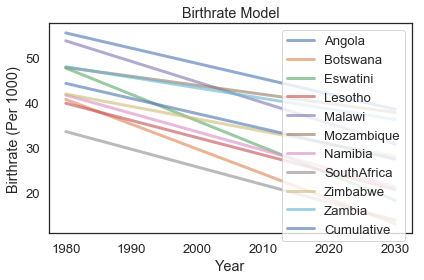

In [800]:
for c in countries:
    plot(c.br_AIDS_model, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Birthrate (Per 1000)',
             title='Birthrate Model')


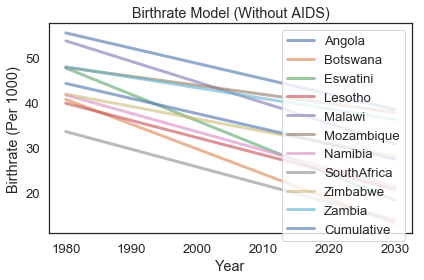

In [801]:
for c in countries:
    plot(c.br_noAIDS_model, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Birthrate (Per 1000)',
             title='Birthrate Model (Without AIDS)')

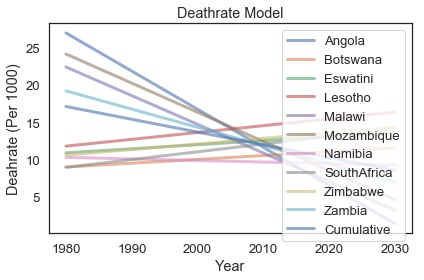

In [802]:
for c in countries:
    plot(c.dr_AIDS_model, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Deahrate (Per 1000)',
             title='Deathrate Model')

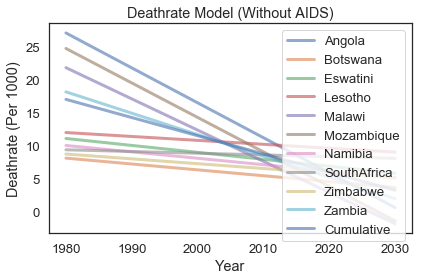

In [803]:
for c in countries:
    plot(c.dr_noAIDS_model, label = c.name)
    
decorate(xlabel='Year', 
             ylabel='Deathrate (Per 1000)',
             title='Deathrate Model (Without AIDS)')

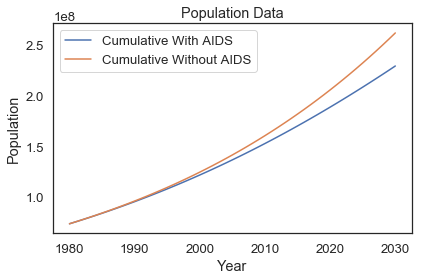

In [804]:
run_simulation(countries[10], True)
run_simulation(countries[10], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Data')

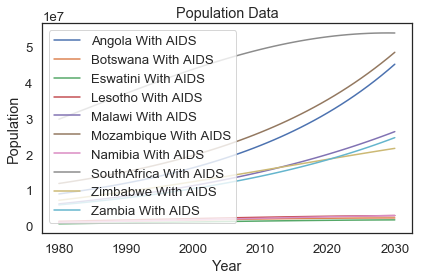

In [805]:
for i in range(10):
    run_simulation(countries[i], True)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Data')

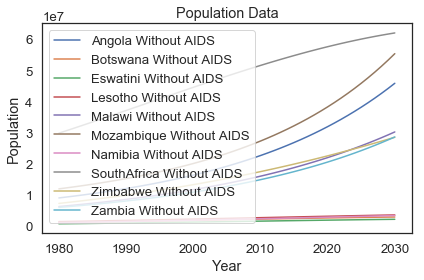

In [806]:
for i in range(10):
    run_simulation(countries[i], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Data')

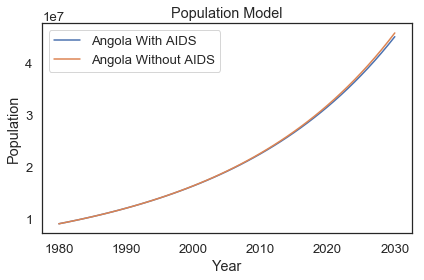

In [807]:
run_simulation(countries[0], True)
run_simulation(countries[0], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

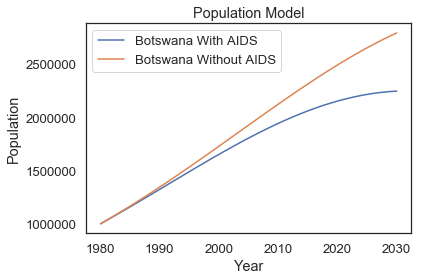

In [808]:
run_simulation(countries[1], True)
run_simulation(countries[1], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

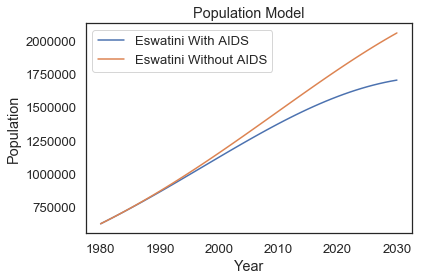

In [809]:
run_simulation(countries[2], True)
run_simulation(countries[2], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

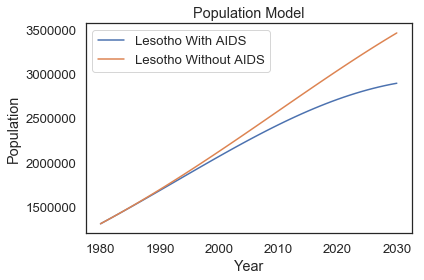

In [810]:
run_simulation(countries[3], True)
run_simulation(countries[3], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

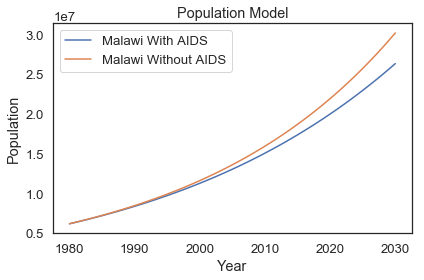

In [811]:
run_simulation(countries[4], True)
run_simulation(countries[4], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

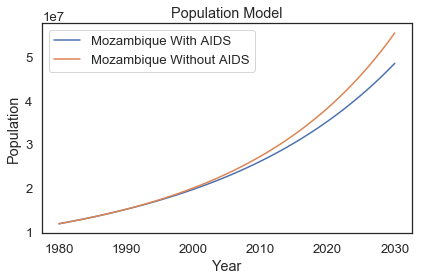

In [812]:
run_simulation(countries[5], True)
run_simulation(countries[5], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

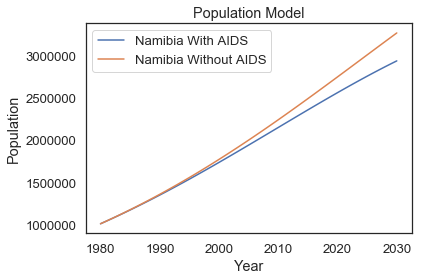

In [813]:
run_simulation(countries[6], True)
run_simulation(countries[6], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

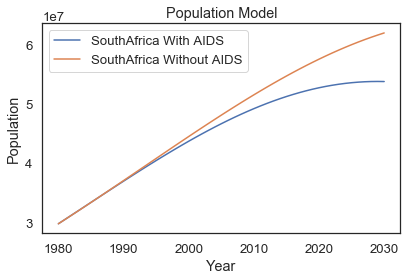

In [814]:
run_simulation(countries[7], True)
run_simulation(countries[7], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

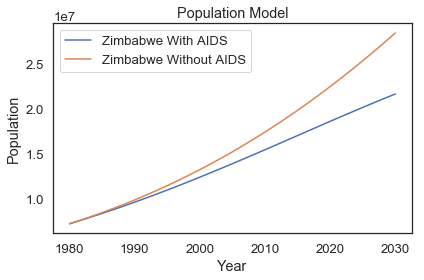

In [815]:
run_simulation(countries[8], True)
run_simulation(countries[8], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

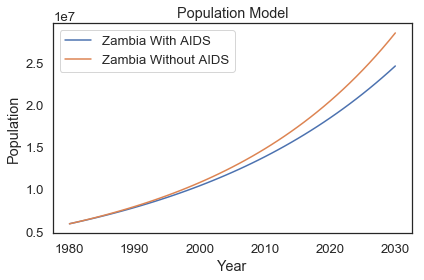

In [816]:
run_simulation(countries[9], True)
run_simulation(countries[9], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')

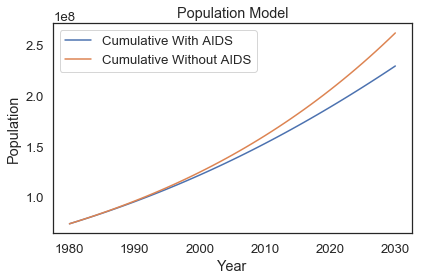

In [817]:
run_simulation(countries[10], True)
run_simulation(countries[10], False)

decorate(xlabel='Year', 
             ylabel='Population',
             title='Population Model')